## Read and clean data

In [1]:
import pandas as pd

In [2]:
datasets = [
    '/Users/stefan/Downloads/processed_tweets_chunks/top100users_processed.csv',
#     '/Users/stefan/Downloads/processed_tweets_chunks/15M_5001_10000.csv',
#     '/Users/stefan/Downloads/processed_tweets_chunks/15M_10000_99999999.csv'
]

In [3]:
%%time 
tweets = pd.concat(
    pd.read_csv(path)
    for path in datasets
).dropna(subset=['text_token'])

CPU times: user 2.94 s, sys: 236 ms, total: 3.18 s
Wall time: 3.2 s


In [4]:
f'{len(tweets):,}'

'203,250'

In [5]:
%time tweets.text_token = tweets.text_token.map(eval)

CPU times: user 7.84 s, sys: 46.5 ms, total: 7.89 s
Wall time: 7.89 s


## words

In [6]:
from collections import Counter

In [7]:
%time word_counts = Counter(t for tokens in tweets.text_token for t in tokens)

CPU times: user 485 ms, sys: 3.9 ms, total: 489 ms
Wall time: 487 ms


In [8]:
word_counts = pd.Series(word_counts)

In [9]:
total_words = word_counts.sum()
n_tweets = len(tweets)
n_unique_words = len(word_counts)

In [10]:
f'{n_unique_words:,}'

'82,084'

In [11]:
f'{total_words:,}'

'2,315,047'

In [12]:
# budget tf-idf
relevant_mask = ((word_counts > .0002 * total_words) &  # at least 0.05% (emoji translations, mispellings, etc)
                 (word_counts < .1   * total_words))   # at most 10% of all (stopwords)

relevant_mask.sum()

565

In [13]:
selected_words = word_counts[relevant_mask].sort_values(ascending=False).index.tolist()

In [14]:
popular_swears = [  # hand-picked, data based
    'shit',
    'damn',
    'bitch',
    'fuck',
    'hell',
    'fucking',
    'nigga',
    'stupid',
    'fuckin',
    'dick',
    'phuck',
    'butt',
    'wtf',
]

In [15]:
selected_words += popular_swears

In [16]:
selected_words = sorted(selected_words)

---

In [17]:
import gensim.downloader

In [18]:
%time glove = gensim.downloader.load('glove-twitter-50')  # also downloads 199MB model

CPU times: user 1min 44s, sys: 915 ms, total: 1min 45s
Wall time: 1min 45s


In [19]:
selected_words = [w for w in selected_words if w in glove]

In [20]:
len(selected_words)

572

## trim

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

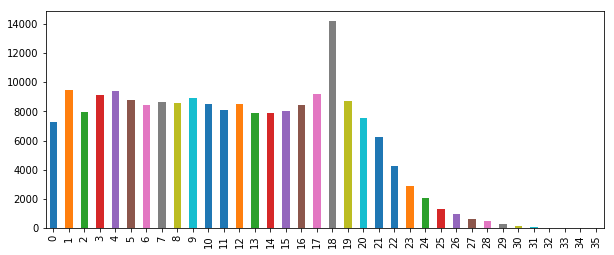

In [22]:
plt.figure(figsize=(10, 4))
tweets.text_token.map(len).value_counts().sort_index().plot(kind='bar')

In [23]:
seq_len = 12  # tokens (after we filter for selected tokens, there will be fewer remaining)
min_seq_len = 4  # will be padded up to seq_len

In [24]:
%%time
tokenized = [
    [t for t in tokens if t in selected_words]
    for tokens in tweets.text_token
]

CPU times: user 22.4 s, sys: 45.2 ms, total: 22.4 s
Wall time: 22.4 s


In [25]:
valid_mask = [min_seq_len <= len(s) <= seq_len for s in tokenized]

In [26]:
tokenized = [s for s, valid in zip(tokenized, valid_mask) if valid]

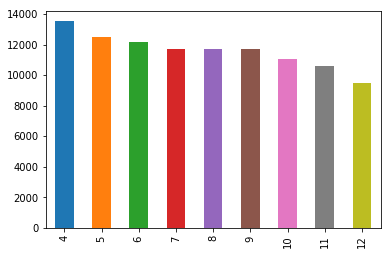

In [27]:
pd.Series(Counter(map(len, tokenized))).sort_index().plot(kind='bar')

In [28]:
%time surviving_words = sorted({t for tokens in tokenized for t in tokens})

CPU times: user 88.1 ms, sys: 9.52 ms, total: 97.6 ms
Wall time: 43.9 ms


In [29]:
n_final_words = len(surviving_words)
n_final_words

570

In [30]:
dictionary = ['_'] + surviving_words

In [115]:
tweets = tweets[valid_mask]
tweets.index = np.arange(len(tweets))

In [32]:
f'{len(tweets):,}'

'104,521'

## encode

In [33]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

Using TensorFlow backend.


In [34]:
le = LabelEncoder()
le.fit(dictionary)

LabelEncoder()

In [71]:
%%time
X = []  # will be indices in the embedding matrix
y = []  # will be one hot encoding
# the ouput won't ever be 0 (or the one hot encoding of zero), so we are wasting one dimension no the output, but we do it for consistency

seqs2tweets = {}

for i, tokens in enumerate(tokenized):
    encoded = le.transform(tokens)
    for j, label in enumerate(encoded[1:]):  # start from one after because we don't want to process the first
        seq = np.zeros(seq_len)
        seq[-j-1:] = encoded[:j+1]  # put the labels at the end

        seqs2tweets[len(X)] = i
        output = to_categorical(label, num_classes=len(dictionary))

        X.append(seq)
        y.append(output)
        
X = np.array(X)
y = np.array(y)

CPU times: user 22.7 s, sys: 1.29 s, total: 24 s
Wall time: 24 s


In [36]:
X.shape

(707346, 12)

In [37]:
y.shape

(707346, 571)

## model

In [38]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from keras.metrics import top_k_categorical_accuracy

import tensorflow as tf

In [39]:
embedding_weights = np.array([np.zeros(glove.vector_size)] +  # padding
                             [glove.get_vector(w) for w in surviving_words])

In [40]:
model = Sequential([
    Embedding(len(dictionary), glove.vector_size, input_length=seq_len,
              weights=[embedding_weights], trainable=False),
    LSTM(128),  # could have it stateful if we provided each user's tweets one after the other
    Dense(y.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

In [41]:
h = model.fit(X, y,
              verbose=1, batch_size=256, epochs=5)

Epoch 1/5
707346/707346 [==============================] - 84s 119us/step - loss: 4.7348 - acc: 0.1277
Epoch 2/5
707346/707346 [==============================] - 81s 115us/step - loss: 4.4001 - acc: 0.1711
Epoch 3/5
707346/707346 [==============================] - 82s 116us/step - loss: 4.2840 - acc: 0.1852
Epoch 4/5
707346/707346 [==============================] - 82s 116us/step - loss: 4.2166 - acc: 0.1927
Epoch 5/5
707346/707346 [==============================] - 82s 117us/step - loss: 4.1704 - acc: 0.1975


---

In [42]:
%time preds = model.predict(X)

CPU times: user 2min 37s, sys: 39.4 s, total: 3min 16s
Wall time: 46.3 s


In [232]:
ranks = (-preds).argsort(axis=1).argsort(axis=1)

In [233]:
labels = y.argmax(axis=1)

In [236]:
correct_rank = np.take_along_axis(ranks, labels[:, np.newaxis], axis=1).reshape(-1)

In [244]:
# manual top k accuracy because keras takes way too much time and sklearn does not have it implemented
for k in [1, 3, 5, 10, 25]:
    acc = (correct_rank < k).mean()
    print(f'top {k} accuracy: {acc:.1%}')

top 1 accuracy: 20.2%
top 3 accuracy: 32.9%
top 5 accuracy: 40.0%
top 10 accuracy: 50.9%
top 25 accuracy: 65.9%


## analyze

In [131]:
import requests

In [133]:
hearders = {'headers':'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:51.0) Gecko/20100101 Firefox/51.0'}

In [266]:
%%time
usernames = {}
for uid in tweets.user_id.unique():
    n = requests.get(f'https://twitter.com/intent/user?user_id={uid}', headers=hearders)
    al = n.text
    title = al[al.find('<title>') + 7 : al.find('</title>')]
    usernames[uid] = title[:-len(' on Twitter')]

CPU times: user 1.44 s, sys: 87.5 ms, total: 1.52 s
Wall time: 18.4 s


---

In [120]:
df = pd.DataFrame(preds[:, swear_indices])
df['tweet_idx'] = [seqs2tweets[i] for i in range(len(X))]

# for each tweet, get the proba of the max swear word, then for each get the max of all subsequences
tweets['swear_proba'] = df.groupby('tweet_idx').max().max(axis=1)

In [145]:
swear_expected = tweets.groupby('user_id').swear_proba.mean().sort_values(ascending=False)
swear_expected.index = [usernames[uid] for uid in swear_expected.index]

In [149]:
pd.options.display.max_rows = 100

In [165]:
swear_expected_relative[::-1]

Kevin Hart (@KevinHart4real)                1.137492
Khloé (@khloekardashian)                    0.717938
Blake Shelton (@blakeshelton)               0.651731
QUEEN (@NICKIMINAJ)                         0.597571
Ariana Grande (@ArianaGrande)               0.565737
Bruno Mars (@BrunoMars)                     0.538525
Wiz Khalifa (@wizkhalifa)                   0.523466
Conan O&#39;Brien (@ConanOBrien)            0.410222
zayn (@zaynmalik)                           0.400475
P!nk (@Pink)                                0.399505
Ellen DeGeneres (@TheEllenShow)             0.390382
Liam (@LiamPayne)                           0.386974
Demi Lovato (@ddlovato)                     0.382681
LeBron James (@KingJames)                   0.380732
daniel tosh (@danieltosh)                   0.333986
Justin Timberlake (@jtimberlake)            0.281812
Rihanna (@rihanna)                          0.280389
Shawn Mendes (@ShawnMendes)                 0.273108
Louis Tomlinson (@Louis_Tomlinson)          0.

<BarContainer object of 83 artists>

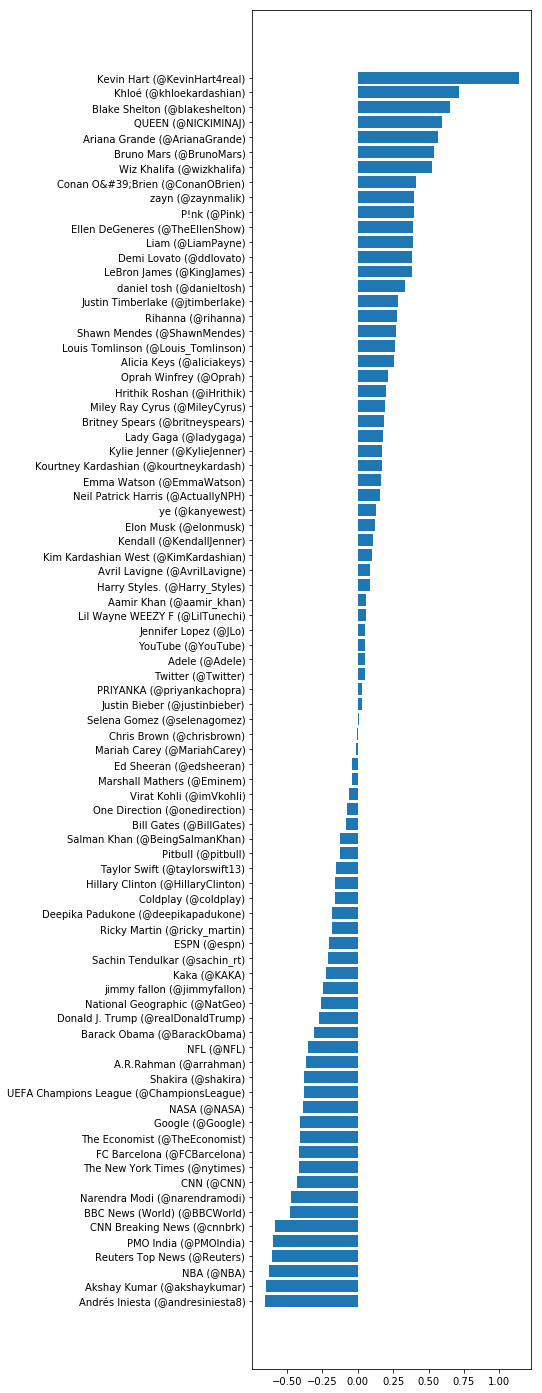

In [163]:
plt.figure(figsize=(5, 25))
swear_expected_relative = swear_expected / swear_expected.mean() - 1
swear_expected_relative.sort_values(inplace=True)
plt.barh(swear_expected_relative.index, swear_expected_relative)

In [124]:
swear_expected[813286] / swear_expected.mean() # obama

0.6879276

In [125]:
swear_expected[25073877] / swear_expected.mean()  # trump

0.7255103

In [126]:
swear_expected[1339835893] / swear_expected.mean()  # hillary

0.8380364

---

In [45]:
swear_indices = [dictionary.index(s) for s in popular_swears]

In [246]:
swear_ranks = pd.DataFrame(ranks[:, swear_indices])
swear_ranks.columns = popular_swears

In [254]:
swear_ranks['engagement'] = [tweets.engagment[seqs2tweets[i]] for i in range(len(X))]
swear_ranks.sort_values(by='engagement', ascending=False, inplace=True)

In [249]:
swear_ranks.describe()

,shit,damn,bitch,fuck,hell,fucking,nigga,stupid,fuckin,dick,phuck,butt,wtf,engagement
count,707346.000000,707346.000000,707346.000000,707346.000000,707346.000000,707346.000000,707346.000000,707346.000000,707346.000000,707346.000000,707346.000000,707346.000000,707346.000000,7.073460e+05
mean,371.393044,329.583002,418.813842,422.583680,423.252714,437.154371,518.463704,511.400094,518.501901,509.798411,512.981498,528.202983,523.537003,3.417994e+04
std,129.488510,130.567082,94.800728,108.848651,99.363883,121.075315,71.873005,85.663035,76.688385,57.565528,68.566976,43.155473,59.045565,1.159730e+05
min,1.000000,5.000000,51.000000,19.000000,7.000000,10.000000,30.000000,17.000000,5.000000,101.000000,23.000000,129.000000,121.000000,0.000000e+00
25%,285.000000,224.000000,367.000000,353.000000,367.000000,372.000000,511.000000,504.000000,515.000000,490.000000,500.000000,519.000000,517.000000,1.319000e+03
50%,402.000000,334.000000,440.000000,456.000000,447.000000,486.000000,546.000000,549.000000,549.000000,531.000000,540.000000,542.000000,546.000000,4.364000e+03
75%,475.000000,444.000000,494.000000,511.000000,502.000000,532.000000,559.000000,562.000000,561.000000,549.000000,555.000000,555.000000,558.000000,1.602500e+04
max,567.000000,566.000000,562.000000,567.000000,566.000000,568.000000,570.000000,570.000000,569.000000,568.000000,569.000000,569.000000,569.000000,4.923959e+06


In [277]:
for sw in popular_swears:
    expected_ranks = swear_ranks[swear_ranks[sw] <= 25]
    print('-'*10, sw, len(expected_ranks), 'sequences have it predicted with rank <= 25\n\n')
    if expected_ranks.empty:
        continue
    
    for seq_idx, ranks in expected_ranks[:20].iterrows():
        tweet = tweets.iloc[seqs2tweets[seq_idx]]
        reconstructed = ' '.join(dictionary[int(label)] for label in X[seq_idx] if label != 0)
        
        print(usernames[tweet.user_id])
        print(reconstructed, '>'*2, f'{sw} (rank {ranks[sw]:.0f})', '<'*2, '...')
        print(tweet.text, '\n\n')

---------- shit 1494 sequences have it predicted with rank <= 25


Ellen DeGeneres (@TheEllenShow)
never seen like this >> shit (rank 19) << ...
You’ve never seen anything like this. BTS. Tomorrow. @BTS_twt #BTSxELLEN #BTSARMY https://t.co/tHeP02OZBy 


zayn (@zaynmalik)
did not the for wa this real fuck >> shit (rank 25) << ...
Didn't realise the hate for minions was this real fuck these aliens got it bad 


Harry Styles. (@Harry_Styles)
i have this some >> shit (rank 15) << ...
I have this some of the time. 


zayn (@zaynmalik)
oh and i my own shit >> shit (rank 24) << ...
Oh and I write my own shit too dickhead 


Liam (@LiamPayne)
i think this >> shit (rank 6) << ...
I think this is my favorite tweet ever ahahahaha https://t.co/n64uvrMJ8Z 


Hillary Clinton (@HillaryClinton)
this but please never stop that >> shit (rank 8) << ...
"This loss hurts. But please never stop believing that fighting for what’s right is worth it." —Hillary 


Marshall Mathers (@Eminem)
tried not this >> sh